<h1>Walk It Off: The Relationship Between Public Transit, Walkability and Wellbeing in 100 U.S. Cities</h1>
<h4>Haley Johnson</h4>

<p>Final project for SI 330, Data Manipulation, at the University of Michigan.</p>
<p>Jupyter notebook with code to create all figured in final report. For more code and analysis, see <a href= "https://github.com/haleyej/330_final_project/blob/main/process_data.ipynb">process_data.ipynb</a> on my github</p>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams
import statsmodels.api as sm
from statsmodels.stats.api import anova_lm
from statsmodels.formula.api import ols
import os 
from scipy.stats import pearsonr

In [2]:
sns.set_style("darkgrid")
sns.color_palette("husl", 9)
sns.set_context("poster")
sns.set(font_scale = 1)

<h2>Manipulate Happiness Data</h2>

In [3]:
html = pd.read_html("happiest_cities.html")

In [4]:
happiness_df = html[0]

<p>Renaming columns for ease of use. In some cases, it can be difficult to reference columns that have a space in their name.</p>

<p>In the cell below, I also split the 'Location' column into two parts: the city and state.</p>

In [5]:
happiness_df = happiness_df.rename(columns = {'City': 'Location', 'Total Score': 'total_score', 
                                              'Emotional & Physical Well-Being':'emotional_physical_wellbeing', 
                                              'Income & Employment': 'income_employment', 
                                              'Community & Environment': 'community_environment'})

happiness_df['state'] = happiness_df['Location'].apply(lambda s: s.split(",")[-1])
happiness_df['city'] = happiness_df['Location'].apply(lambda s: s.split(",")[0])

happiness_df = happiness_df.drop(columns = ['Location'])

In [6]:
happiness_df['state'] = happiness_df['state'].str.strip().str.upper()
happiness_df['city'] = happiness_df['city'].str.strip().str.upper()

<h2>Manipulate Transportation Data</h2>

In [7]:
locations_df = pd.read_csv("EPA_SmartLocationDatabase_V3_Jan_2021_Final.csv")

<h4>Remove Rows Where Location Is Missing</h4>

<p>I will be using the CBSA_Name column to join the two datasets, so I'm removing any instances where CBSA_Name is null. There are no other columns that have missing values.</p>

In [8]:
locations_df = locations_df[pd.isnull(locations_df['CBSA_Name']) == False]

In [9]:
for col in list(locations_df.columns):
    subset = locations_df[col]
    counts = pd.isnull(subset)
    counts = counts.value_counts()
    if True in counts.values:
        print(f"{col} contains missing values")

<h4>Missing Values in D4A column</h4>
<p>D4A measures the distance from the population center to the nearest transit stop. If there are not transit stops in that area, the value is reported as -9999.00</p>

<p>This makes plots of D4A difficult to interpret. For the sake of this analysis, we'll change -9999.00 to None.</p>

In [10]:
locations_df['D4A'] = locations_df['D4A'].replace(-99999.00, None)

<h4>Setting Ranking Columns as Category</h4>

In [11]:
rankings = ['D2A_Ranked', 'D2B_Ranked', 'D3B_Ranked', 'D4A_Ranked']

for rank in rankings:
    locations_df[rank] = locations_df[rank].astype('category')

<h4>Get City and State Names</h4>
<p>Splitting CBSA_Name into the city and state</p>

In [12]:
locations_df['CBSA_Name'] = locations_df['CBSA_Name'].astype(str)

In [13]:
locations_df['metro_area_cities'] = locations_df['CBSA_Name'].apply(lambda s: str(s).split(",")[0])
locations_df['metro_area_states'] = locations_df['CBSA_Name'].apply(lambda s: str(s).split(",")[-1])

locations_df['city'] = locations_df['metro_area_cities'].apply(lambda s: s.split("-"))
locations_df['state'] = locations_df['metro_area_states'].apply(lambda s: s.split("-"))

In [14]:
locations_df = locations_df.drop(columns = ['metro_area_cities', 'metro_area_states'])

<h3>Explode</h3>

<p>Many census blocks associated with more than one city or state in the CBSA_Name column (i.e. blocks that are part of the New York City metro area and the Jersey City metro area). To get one row for each city/state combo the data is associated with, we'll use .explode()</p>

In [15]:
exploded = locations_df.explode('city')
exploded = exploded.explode('state')
exploded = exploded.drop_duplicates()

In [16]:
exploded['city'] = exploded['city'].str.strip().str.upper()
exploded['state'] = exploded['state'].str.strip().str.upper()

<h2>Joining Happiness and Transportation Dataframes</h2>

<h4>Check that columns match</h4>
<p>There is some subjectivity in how city name's are represented (i.e. 'Mount' vs 'Mt.', 'New York City' vs 'New York.' To check for consistency between the two datasets, we'll examined three edge cases</p>

<p><b>St. Paul Minnestoa</b></p>

In [17]:
happiness_df[happiness_df['state'] == 'MN'][['city', 'state']]

,city,state
11,MINNEAPOLIS,MN
45,ST. PAUL,MN


In [18]:
exploded[exploded['state'] == 'MN'][['city', 'state']].head()

,city,state
125050,MINNEAPOLIS,MN
125050,ST. PAUL,MN
125050,BLOOMINGTON,MN
125051,MINNEAPOLIS,MN
125051,ST. PAUL,MN


<p><b>New York City, NY</b></p>

In [19]:
happiness_df[happiness_df['state'] == 'NY'][['city', 'state']]

,city,state
43,YONKERS,NY
57,NEW YORK,NY
130,ROCHESTER,NY
135,BUFFALO,NY


In [20]:
exploded[(exploded['state'] == 'NY') & (exploded['city'] == 'NEW YORK')][['city', 'state']].head()

,city,state
141064,NEW YORK,NY
141065,NEW YORK,NY
141066,NEW YORK,NY
141067,NEW YORK,NY
141068,NEW YORK,NY


<p><b>Washington, D.C.</b></p>

In [21]:
happiness_df[happiness_df['state'] == 'DC'][['city', 'state']]

,city,state
84,WASHINGTON,DC


In [22]:
exploded[exploded['state'] == 'DC'][['city', 'state']].head()

,city,state
15824,WASHINGTON,DC
15824,ARLINGTON,DC
15824,ALEXANDRIA,DC
15825,WASHINGTON,DC
15825,ARLINGTON,DC


<h4>Joining</h4>

In [23]:
matches = exploded.merge(happiness_df, on = ['state', 'city'])

In [24]:
vals = list(matches.columns)[11:-8] + list(happiness_df.columns)[:-2]
df = pd.pivot_table(matches, index = ['city', "state"], values = vals, aggfunc = 'mean')

In [25]:
df = df.reset_index()

<h4>Add in Regions</h4>

<p>Based on <a href="https://www2.census.gov/geo/pdfs/maps-data/maps/reference/us_regdiv.pdf">census designations</a></p>

In [26]:
regions = {}

regions['Pacific'] = ['CA', 'OR', 'WA', 'HI', 'AK']

regions['Mountain West'] = ['ID', 'NV', 'MT','WY', 'UT', 'CO', 'AZ', 'NM']

regions['West North Central'] = ['ND', 'SD', 'NE', 'KS', 'MN', 'IA', 'MO']

regions['West South Central'] = ['TX', 'OK', 'AR', 'LA']

regions['East North Central'] = ['WI', 'IL', 'MI', 'IN', 'OH']

regions['East South Central'] = ['KY', 'TN', 'MS', 'AL']

regions['South Atlantic'] = ['FL', 'GA', 'SC', 'NC', 'VA', 'WV', 'DC', 'MD', 'DE']

regions['Middle Atlantic'] = ['PA', 'NY', 'NJ']

regions['New England'] = ['ME', 'VT', 'NH', 'MA', 'CT', 'RI']

regions['US Territories'] = ['PR']

In [27]:
def get_region(s):
    keys = list(regions.keys())
    for key in keys:
        if s in regions[key]:
            return key
    return None

In [28]:
df['Region'] = df['state'].apply(get_region)

<h2>Data Visualization</h2>

<h3>Example of Why Aggregation Is Helpful</h3>

<p>Credit to <a href = "https://matplotlib.org/stable/gallery/text_labels_and_annotations/annotation_demo.html">this</a> MatPlotLib tutorial for helping me annotate my plots</p>

Text(0.5, 0.98, 'Effect of Aggregating by City on Analysis')

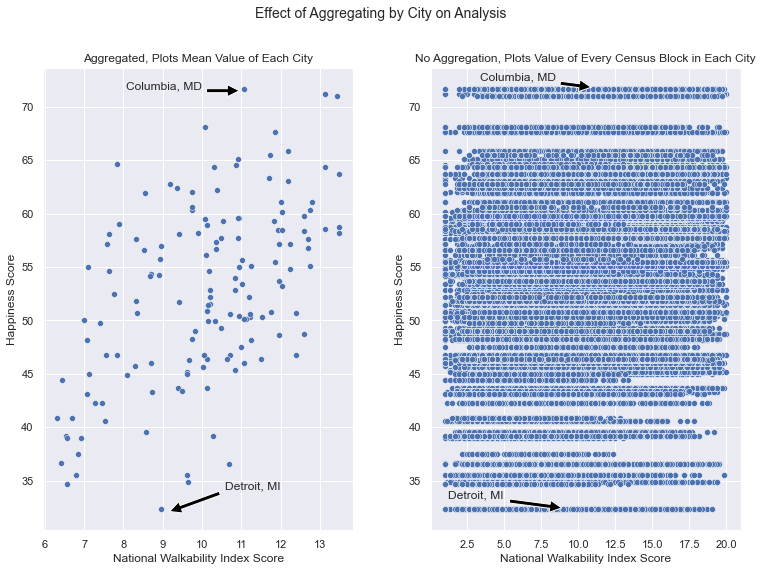

In [29]:
fig, axes = plt.subplots(1, 2)
fig.set_size_inches(12.5, 8.5)
fig.subplots_adjust(hspace=0.5, wspace = 0.25)

sns.scatterplot(x = 'NatWalkInd', y = 'total_score', data = df, ax = axes[0])
sns.scatterplot(x = 'NatWalkInd', y = 'total_score', data = matches, ax = axes[1])

# labels
axes[0].set_title('Aggregated, Plots Mean Value of Each City')
axes[0].set(ylabel = 'Happiness Score', xlabel = 'National Walkability Index Score')
axes[1].set_title('No Aggregation, Plots Value of Every Census Block in Each City')
axes[1].set(ylabel = 'Happiness Score', xlabel = 'National Walkability Index Score')

# annotations
axes[0].annotate('Detroit, MI',
            xy=(9.1, 32), xycoords='data',
            xytext=(12, 34), textcoords='data',
            arrowprops=dict(facecolor='black', shrink=0.05),
            horizontalalignment='right', verticalalignment='bottom')
axes[0].annotate('Columbia, MD',
            xy=(11, 71.5), xycoords='data',
            xytext=(10, 71.5), textcoords='data',
            arrowprops=dict(facecolor='black', shrink=0.05),
            horizontalalignment='right', verticalalignment='bottom')

axes[1].annotate('Detroit, MI',
            xy=(9.1, 32.4), xycoords='data',
            xytext=(5, 33.15), textcoords='data',
            arrowprops=dict(facecolor='black', shrink=0.05),
            horizontalalignment='right', verticalalignment='bottom')
axes[1].annotate('Columbia, MD',
            xy=(11, 71.8), xycoords='data',
            xytext=(8.5, 72.25), textcoords='data',
            arrowprops=dict(facecolor='black', shrink=0.05),
            horizontalalignment='right', verticalalignment='bottom')

fig.suptitle("Effect of Aggregating by City on Analysis", fontsize = 14)

<h3>General Relationship Between Transit, Walkability & Happinness</h3>

Text(0.5, 0.98, 'Relationship Between Transit, Walkability, and Happiness')

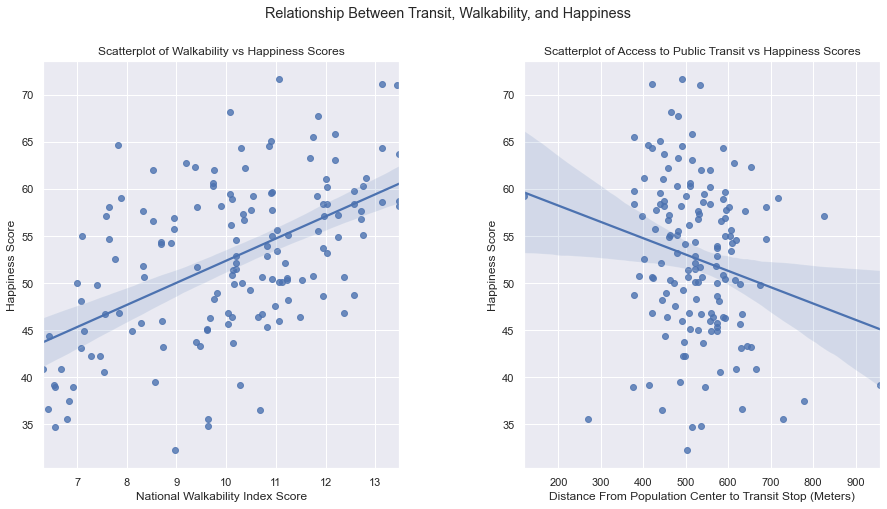

In [30]:
fig, axes = plt.subplots(1, 2)
fig.set_size_inches(15, 7.5)
fig.subplots_adjust(hspace = 0.5, wspace = 0.35)

axes[0] = sns.regplot(x = 'NatWalkInd', y = 'total_score', data = df, ax = axes[0])
axes[0].set(xlabel = 'National Walkability Index Score', ylabel = 'Happiness Score')
axes[0].set_title("Scatterplot of Walkability vs Happiness Scores")

axes[1] = sns.regplot(x = 'D4A', y = 'total_score', data = df, ax = axes[1])
axes[1].set(xlabel = 'Distance From Population Center to Transit Stop (Meters)', ylabel = 'Happiness Score')
axes[1].set_title("Scatterplot of Access to Public Transit vs Happiness Scores")

fig.suptitle("Relationship Between Transit, Walkability, and Happiness")

<p>Credit to <a href = "https://machinelearningmastery.com/how-to-use-correlation-to-understand-the-relationship-between-variables/">this</a> tutrial for helping me calculate correlation</p>

In [31]:
corr, _ = pearsonr(df['total_score'], df['D4A'])
print(corr)

-0.2046791238931847


In [32]:
corr, _ = pearsonr(df['total_score'], df['NatWalkInd'])
print(corr)

0.5252033893429153


<h3>Pedestrian Intersections</h3>

Text(0.5, 1.0, 'Ranking of Density of Pedestrian Street Intersections')

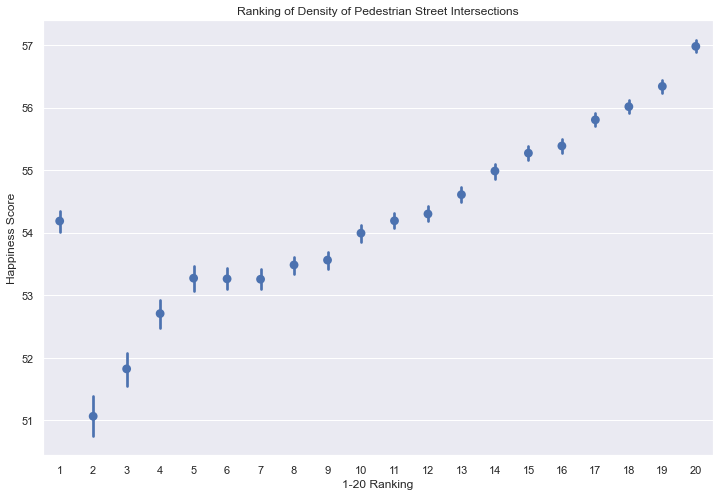

In [46]:
g = sns.pointplot(x = 'D3B_Ranked', y = 'total_score', data = matches, join = False)
g.set_xticklabels(g.get_xticklabels())
g.set_xlabel(xlabel = '1-20 Ranking')
g.set_ylabel('Happiness Score')
g.set_title('Ranking of Density of Pedestrian Street Intersections')

Credit to <a href="https://stackoverflow.com/questions/33049884/how-to-plot-2-seaborn-lmplots-side-by-side">this</a> Stackoverflow post for helping me create subplots with seaborn regplots. 

Text(0.5, 1.0, 'Scatterplot of Access to Transit vs Population Density')

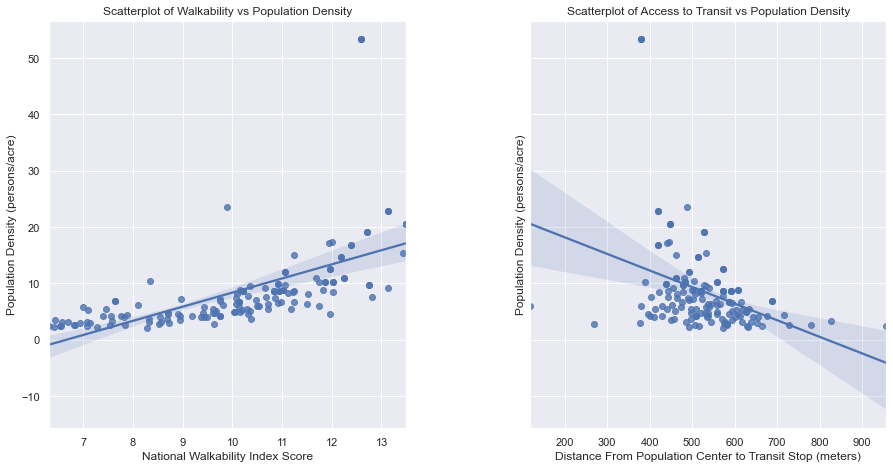

In [39]:
fig, (ax1, ax2) = plt.subplots(ncols = 2, sharey = True)
fig.set_size_inches(15, 7.5)
fig.subplots_adjust(hspace = 0.5, wspace = 0.35)

f1 = sns.regplot(x = 'NatWalkInd', y = 'D1B', data = df, ax = ax1)
f1.set(xlabel = 'National Walkability Index Score', ylabel = 'Population Density (persons/acre)')
f1.set_title("Scatterplot of Walkability vs Population Density")

f2 = sns.regplot(x = 'D4A', y = 'D1B', data = df, ax = ax2)
f2.set(xlabel = 'Distance From Population Center to Transit Stop (meters)', ylabel = 'Population Density (persons/acre)')
f2.set_title("Scatterplot of Access to Transit vs Population Density")

<h3>Variations by Region</h3>

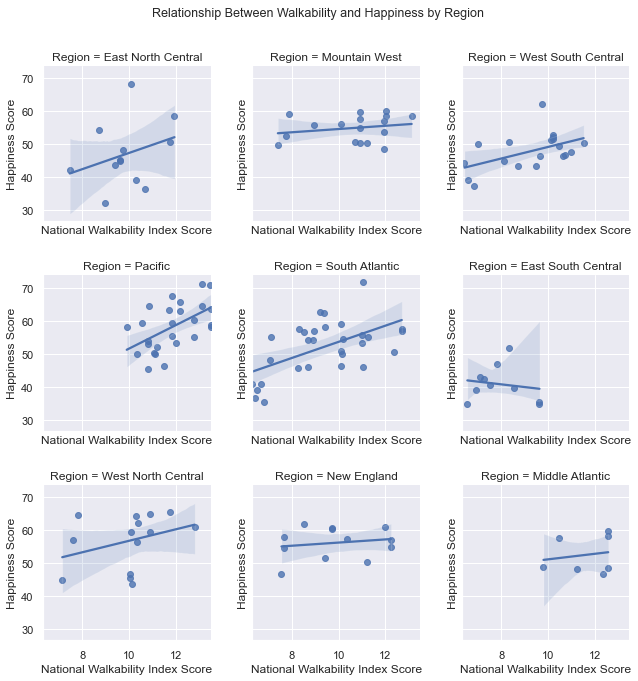

In [41]:
g = sns.FacetGrid(df, col = "Region", col_wrap = 3)
g.map(sns.regplot, "NatWalkInd", "total_score")
g.set(xlabel = 'National Walkability Index Score', ylabel = 'Happiness Score')

g.fig.suptitle("Relationship Between Walkability and Happiness by Region", y = 1.05, fontsize = 12.5)
g.fig.subplots_adjust(wspace = 0.25, hspace = 0.35)

<h3>Walkability vs Density</h3>

In [42]:
by_region = df.groupby('Region')
happiness_by_region = by_region.describe()['total_score'].sort_values(by = 'mean', ascending = False)
happiness_by_region = happiness_by_region.rename(columns = {'mean': 'average_happiness_score'})

walkability_by_region = by_region.describe()['NatWalkInd'].sort_values(by = 'mean', ascending = False)
walkability_by_region = walkability_by_region.rename(columns = {'mean': 'average_walkability_score'})

happiness_by_region = happiness_by_region['average_happiness_score']
walkability_by_region = walkability_by_region['average_walkability_score']

regional_variations = pd.concat([happiness_by_region, walkability_by_region], axis = 1)

In [43]:
regional_variations

,average_happiness_score,average_walkability_score
Region,,
Pacific,58.197692,11.856247
West North Central,56.905000,10.016230
New England,56.260000,9.863358
Mountain West,54.908824,10.636201
Middle Atlantic,52.642857,11.668197
South Atlantic,51.932667,9.306112
West South Central,47.870000,9.262742
East North Central,47.002500,9.851519
East South Central,40.815000,7.936037


<h4>Statistical Tests for Different in Mean Across Regions</h4>

In [44]:
lm = ols('total_score ~ NatWalkInd', data = df).fit()
regions_lm = ols('total_score ~ Region + NatWalkInd', data = df).fit()

table1 = anova_lm(lm, regions_lm)
print(table1)

   df_resid          ssr  df_diff      ss_diff         F    Pr(>F)
0     145.0  7380.089644      0.0          NaN       NaN       NaN
1     137.0  5658.967775      8.0  1721.121869  5.208408  0.000011


In [45]:
print(regions_lm.summary())

                            OLS Regression Results                            
Dep. Variable:            total_score   R-squared:                       0.445
Model:                            OLS   Adj. R-squared:                  0.408
Method:                 Least Squares   F-statistic:                     12.19
Date:                Wed, 13 Apr 2022   Prob (F-statistic):           5.05e-14
Time:                        18:02:52   Log-Likelihood:                -476.90
No. Observations:                 147   AIC:                             973.8
Df Residuals:                     137   BIC:                             1004.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept       